In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Step 1. 스티커 구하기 or 만들기

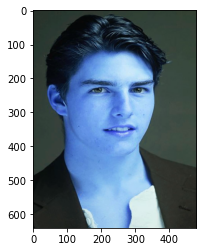

In [49]:
import os
my_image_path = os.getenv('HOME')+'/Project/[Pr.3] camera_sticker/images/tom.jpeg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 480x640의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

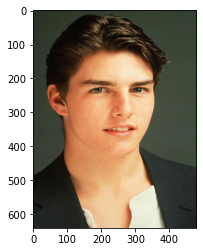

In [50]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출하기

In [51]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(111, 171) (379, 439)]]


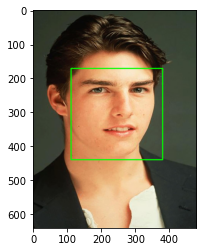

In [52]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [53]:
print(dlib_rects)

rectangles[[(111, 171) (379, 439)]]


In [54]:
import os
model_path = os.getenv('HOME')+'/Project/[Pr.3] camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [58]:
list_landmarks = []
# print(dlib_rects)
for dlib_rect in dlib_rects:
    # print(dlib_rect)
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

rectangles[[(111, 171) (379, 439)]]
[(111, 171) (379, 439)]
68


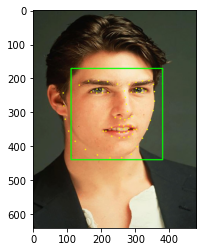

In [56]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] ## - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    # w = 350
    # h = 300
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(276, 297)
(x,y) : (276,297)
(w,h) : (269,269)


In [10]:
import os
sticker_path = os.getenv('HOME')+'/Project/[Pr.3] camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(269, 269, 3)


## Step 3. 스티커 적용 위치 확인하기

In [11]:
refined_x = x - w // 2        # left
refined_y = y - (h // 2) + 10 # top (+10 means location of sticker nose)

# refined_x = x - 50
# refined_y = y - 50
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (142,173)


In [12]:
print(img_sticker.shape[0], img_sticker.shape[1])

269 269


## Step 4. 스티커 적용하기

In [13]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

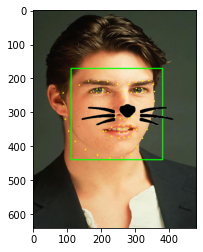

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

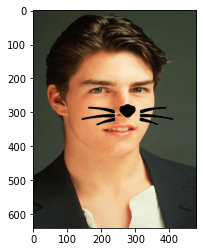

In [15]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5. 문제점 찾아보기

#### - 얼굴 각도에 따라 스티커가 어떻게 변해야 할까요?
    
예를 들어서 정면 사진에는 스티커가 크게 수정될 필요가 없겠지만, 측면 사진이나 사진의 구도가 바뀔 경우 그에 맞게 스티커의 각도도 변해야 한다고 생각한다.

#### - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    
멀리서 촬영하면 안되는 이유는 사진에서 얼굴을 탐지하기 어렵기 때문으로 생각된다. 얼굴 영역을 bounding box로 표시하는 과정에서 사진의 비율이 비정상적이거나 너무 작게되면 bbox로 표시되지 않는 오류를 발견하였다. 이는 얼굴의 전체적인 윤곽선을 탐지해 얼굴임을 인지하게 되는 원리이기 때문에 사진의 가로의 비율이 너무 크거나 세로의 비율이 너무 큰 경우, 혹은 사진에 나타나는 얼굴의 크기가 너무 작은 경우 얼굴로 인식하지 못하는 것 같다.
    

    
    
#### - 실행 속도가 중요할까요? 스티커 앱을 만들 때 정확도가 얼마나 중요할까요?
    
물론 어느정도의 실행 속도는 중요하다고 생각하지만, 자율주행차량처럼 즉각적인 반응을 필요로 하는 상황을 요구하지는 않기 때문에, 사람 얼굴에 대한 인식 속도보다 landmark를 통해 사람의 얼굴임을 정확하게 인지하는 정확도가 더 중요하다고 생각한다.

## Extra Step

- 기존의 사진을 90도 회전시켜 적용해보기
    
마치 누워서 사진을 찍은 것처럼 원본 사진을 90도로 회전시켰는데, 얼굴 영역을 제대로 찾지 못하는 것을 확인하였다. (왜지..?)
    
    
##### 이부분에 대한 내용은 cat_whiskers_ROTATE.ipynb 파일에서 따로 다루었다.

- 다양한 사진에 적용해보기(1) - 평범한 정면 사진

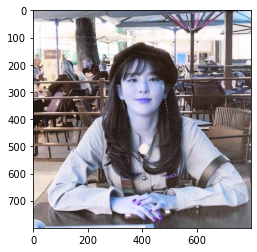

In [23]:
import os
new_image_path = os.getenv('HOME')+'/Project/[Pr.3] camera_sticker/images/sk.jpg'
img_bgr = cv2.imread(new_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (800, 800))    # 800x800의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

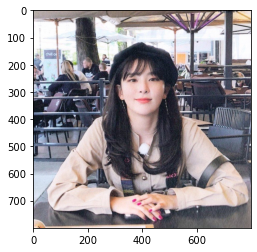

In [24]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(322, 219) (476, 374)]]


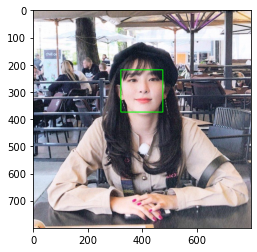

In [25]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [26]:
import os
model_path = os.getenv('HOME')+'/Project/[Pr.3] camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


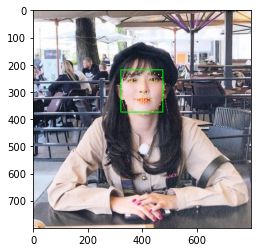

In [27]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [28]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] ## - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    # w = 300
    # h = 250
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(405, 289)
(x,y) : (405,289)
(w,h) : (155,155)


In [29]:
import os
sticker_path = os.getenv('HOME')+'/Project/[Pr.3] camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(155, 155, 3)


In [30]:
refined_x = x - w // 2        # left
refined_y = y - (h // 2) + 10 # top (+10 means location of sticker nose)

# refined_x = x - 50
# refined_y = y - 50
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (328,222)


In [31]:
print(img_sticker.shape[0], img_sticker.shape[1])

155 155


In [32]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

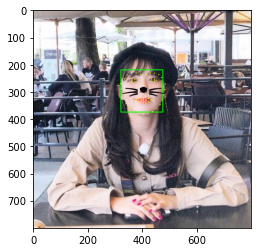

In [33]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

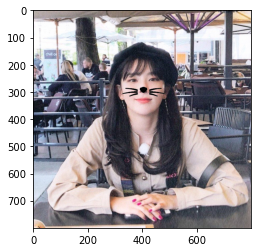

In [34]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 다양한 사진에 적용해보기(2) - 거리가 좀 있고, 사람이 2명 이상인 경우

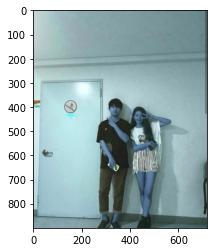

In [35]:
import os
my_image_path = os.getenv('HOME')+'/Project/[Pr.3] camera_sticker/images/together.jpeg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (720, 900))    # 720x900의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

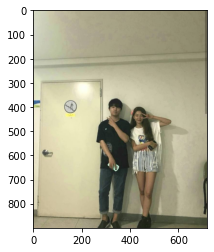

In [36]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [37]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(419, 420) (463, 463)], [(314, 383) (366, 435)]]


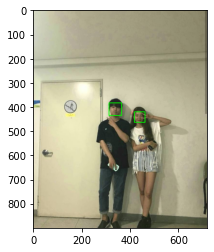

In [38]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [39]:
import os
model_path = os.getenv('HOME')+'/Project/[Pr.3] camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [40]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# print(list_landmarks)
print(len(list_landmarks))

2


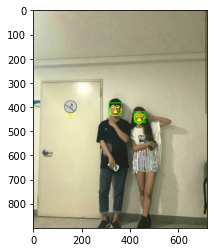

In [41]:
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [42]:
i = 1
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
       
    globals()['x{}'.format(i)] = landmark[30][0]
    globals()['y{}'.format(i)] = landmark[30][1] ## - dlib_rect.width()//2
    globals()['w{}'.format(i)] = dlib_rect.width()
    globals()['h{}'.format(i)] = dlib_rect.width()
    i += 1

    
print ('(x1,y1) : (%d,%d)'%(x1,y1))
print ('(w1,h1) : (%d,%d)'%(w1,h1))

print ('(x2,y2) : (%d,%d)'%(x2,y2))
print ('(w2,h2) : (%d,%d)'%(w2,h2))

(439, 447)
(341, 411)
(x1,y1) : (439,447)
(w1,h1) : (45,45)
(x2,y2) : (341,411)
(w2,h2) : (53,53)


In [43]:
import os
sticker_path = os.getenv('HOME')+'/Project/[Pr.3] camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker1 = cv2.resize(img_sticker, (w1,h1))
img_sticker2 = cv2.resize(img_sticker, (w2,h2))
print (img_sticker.shape)

(512, 512, 3)


In [44]:
refined_x1 = x1 - w1 // 2        # left
refined_y1 = y1 - (h1 // 2) + 10 # top (+10 means location of sticker nose)

refined_x2 = x2 - w2 // 2        # left
refined_y2 = y2 - (h2 // 2) + 10 # top (+10 means location of sticker nose)

# refined_x = x - 50
# refined_y = y - 50
print ('(x,y) : (%d,%d)'%(refined_x1, refined_y1))
print ('(x,y) : (%d,%d)'%(refined_x2, refined_y2))
print(img_sticker1.shape[0], img_sticker1.shape[1])
print(img_sticker2.shape[0], img_sticker2.shape[1])

(x,y) : (417,435)
(x,y) : (315,395)
45 45
53 53


In [45]:
sticker_area1 = img_show[refined_y1:refined_y1+img_sticker1.shape[0], refined_x1:refined_x1+img_sticker1.shape[1]]
img_show[refined_y1:refined_y1+img_sticker1.shape[0], refined_x1:refined_x1+img_sticker1.shape[1]] = \
    np.where(img_sticker1==255,sticker_area1,img_sticker1).astype(np.uint8)

sticker_area2 = img_show[refined_y2:refined_y2+img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]]
img_show[refined_y2:refined_y2+img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]] = \
    np.where(img_sticker2==255,sticker_area2,img_sticker2).astype(np.uint8)

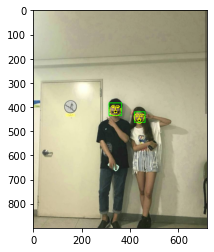

In [46]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

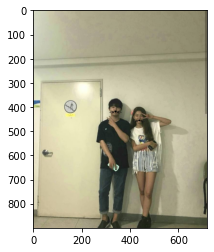

In [47]:
sticker_area1 = img_bgr[refined_y1:refined_y1+img_sticker1.shape[0], refined_x1:refined_x1+img_sticker1.shape[1]]
img_bgr[refined_y1:refined_y1+img_sticker1.shape[0], refined_x1:refined_x1+img_sticker1.shape[1]] = \
    np.where(img_sticker1==255,sticker_area1,img_sticker1).astype(np.uint8)

sticker_area2 = img_bgr[refined_y2:refined_y2+img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]]
img_bgr[refined_y2:refined_y2+img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]] = \
    np.where(img_sticker2==255,sticker_area2,img_sticker2).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

### * 이번 프로젝트에서 어려웠던 점.
    
    사람이 마치 누워서 찍은 듯한(-90도 회전) 사진을 적용해보려고 했지만, 성공하지 못했다. (landmark를 정확하게 찾지 못한다.)
    처음에는 단순히 landmark.dat 파일이 정면 사진만 식별하게끔 되어있다고 생각해서 이부분에 대해 전체적으로 point를 하나하나 -90도로 회전한 다음에 적용해보았지만 이마저도 실패하였다. (x, y) -> (y, -x) : 반시계방향 90도 회전변환 이용
    
    
    
### * 프로젝트를 진행하면서 알아낸 점 혹은 모호한 점.

    모호한 점은 위의 프로젝트에서 어려웠던 점과 내용이 같습니다.
    90도로 회전한 사진에 대해서 landmark를 찾아내지 못하는 점이 이해가 되지 않습니다. (단순히 dat 파일이 정면 사진만 표현되어서 인식하지 못하는 거라고 생각해서 landmark point 하나하나 회전변환을 시켜주어 출력해보았지만, plt로 찍어내는 과정에서 변경사항을 발견하지 못했습니다.)
    
    알아낸 점은 회전 사진의 경우 hog_detector가 얼굴 bbox 영역을 찾지 못해 검색해보니 cnn_face_detection_model이 얼굴 인식하는데 있어 더 뛰어난 성능을 보인다는 글을 읽게되었습니다. 
    또한, 사진에 여러명이 같이 있는 경우 LMS 상의 코드로 진행하게 되면 나중에 인식되는 landmark에만 스티커가 붙여진다는 것을 확인하고, 이 부분을 수정하였습니다.
    


### * 루브릭 평가 지표를 맞추기 위해 시도한 것들.
    
    
1) 자기만의 카메라 앱 기능 구현을 완수하였다. (원본에 스티커 사진이 정상적으로 합성되었는가?)    

    네. 원본 이미지에 고양이 수염 스티커가 정상적으로 합성되는 것을 확인하였습니다.

2) 스티커 이미지를 정확한 원본 위치에 반영하였다. (정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었는가?)
    
    네. landmark 코 부분의 좌표와 고양이 수염 모양을 토대로 좌표 계산을 하여 원본 이미지의 자연스러운 위치에 스티커가 붙여지도록 설정하였습니다.

3) 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다. (얼굴 각도, 이미지 밝기, 촬영 거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였는가?)
    
    네. 기본 정면 사진 외에 조금 멀리 떨어진 사진, 그보다 더 멀리 떨어진 2명이상의 사진, 누워있는 듯한 사진(90도 회전) 등으로 카메라 스티커앱에서 생길 수 있는 문제점들에 대해 파악해보려 노력했습니다. 대부분의 사진에서 제대로 기능하는 것을 확인했지만, 유일하게 90도를 회전한 사진에 대해서 landmark를 찾아가는 부분에서 막혀 수행하지 못했습니다. (이부분에 대한 해결을 알고싶습니다!!!)
    

    
    
### * 다짐

저번주에 잠깐 정신팔았더니 노드며, 블로그 정리며 밀린 것들이 많아졌다. 정신차리고 빠르게 하나씩 하나씩 메꿔나가야겠다.

